In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
from bs4 import BeautifulSoup
from env import github_token, github_username
import pandas as pd
import nltk
from requests import get
from bs4 import BeautifulSoup, SoupStrainer
import re
import unicodedata
from scipy import stats
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from env import get_connection

In [2]:

"""
A module for obtaining repo readme and language data from the github API.
Before using this module, read through it, and follow the instructions marked
TODO.
After doing so, run it like this:
    python acquire.py
To create the `data.json` file that contains the data.
"""


# TODO: Make a github personal access token.
#     1. Go here and generate a personal access token: https://github.com/settings/tokens
#        You do _not_ need select any scopes, i.e. leave all the checkboxes unchecked
#     2. Save it in your env.py file under the variable `github_token`
# TODO: Add your github username to your env.py file under the variable `github_username`
# TODO: Add more repositories to the `REPOS` list below.

REPOS = [
    "gocodeup/codeup-setup-script",
    "gocodeup/movies-application",
    "torvalds/linux",
]

headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )


def github_api_request(url: str) -> Union[List, Dict]:
    response = requests.get(url, headers=headers)
    response_data = response.json()
    if response.status_code != 200:
        raise Exception(
            f"Error response from github api! status code: {response.status_code}, "
            f"response: {json.dumps(response_data)}"
        )
    return response_data


def get_repo_language(repo: str) -> str:
    url = f"https://api.github.com/repos/{repo}"
    repo_info = github_api_request(url)
    if type(repo_info) is dict:
        repo_info = cast(Dict, repo_info)
        if "language" not in repo_info:
            raise Exception(
                "'language' key not round in response\n{}".format(json.dumps(repo_info))
            )
        return repo_info["language"]
    raise Exception(
        f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
    )


def get_repo_contents(repo: str) -> List[Dict[str, str]]:
    url = f"https://api.github.com/repos/{repo}/contents/"
    contents = github_api_request(url)
    if type(contents) is list:
        contents = cast(List, contents)
        return contents
    raise Exception(
        f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
    )


def get_readme_download_url(files: List[Dict[str, str]]) -> str:
    """
    Takes in a response from the github api that lists the files in a repo and
    returns the url that can be used to download the repo's README file.
    """
    for file in files:
        if file["name"].lower().startswith("readme"):
            return file["download_url"]
    return ""


def process_repo(repo: str) -> Dict[str, str]:
    """
    Takes a repo name like "gocodeup/codeup-setup-script" and returns a
    dictionary with the language of the repo and the readme contents.
    """
    contents = get_repo_contents(repo)
    readme_download_url = get_readme_download_url(contents)
    if readme_download_url == "":
        readme_contents = ""
    else:
        readme_contents = requests.get(readme_download_url).text
    return {
        "repo": repo,
        "language": get_repo_language(repo),
        "readme_contents": readme_contents,
    }


def scrape_github_data() -> List[Dict[str, str]]:
    """
    Loop through all of the repos and process them. Returns the processed data.
    """
    return [process_repo(repo) for repo in REPOS]




In [3]:
hrefs = [] 
for p in range(1,11):
    url = f'https://github.com/search?p={p}&q=Hacktoberfest&type=Repositories'
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'html.parser')
    links = soup.find_all("a", {"class": "v-align-middle"})
    links = [l['href'] for l in links]
    hrefs.append(links)
    
flat_list = [item for sublist in hrefs for item in sublist]

In [4]:
def jupy_replace(df):
    new_lang = ['C++', 'C++','C++','python','python','python', 'python', 'python',
                 'python', 'python', 'python', 'python', 'python', 'C++',
                 'python', 'C++', 'python', 'python', 'python', 'HTML', 'python',
                 'Javascript']
    repo_mod = pd.DataFrame(df[df['language']== 'Jupyter Notebook']['repo'])
    repo_mod['new_lang'] = new_lang
    for x in repo_mod.index:
        df.loc[x, 'language'] = repo_mod.loc[x, 'new_lang']
        
    return df

In [5]:
df = pd.read_json('data.json')

In [6]:
df = jupy_replace(df)
df

,repo,language,readme_contents
0,/AliceWonderland/hacktoberfest,HTML,# 🎃 HacktoberFest Starter Project 🎃\n\n** __Oc...
1,/fineanmol/Hacktoberfest2022,Python,Hacktoberfest-2022\n\n**Checkout this Project ...
2,/keshavsingh4522/hacktoberfest2021,C++,"<div align=""centre"">\n <b>dont contribute i..."
3,/ossamamehmood/Hacktoberfest2022,C++,# HacktoberFest 2022 `OPEN FIRST` Pull Request...
4,/tarunsinghofficial/HacktoberFest,Java,# HacktoberFest- Contribute to Open-Source.\n\...
...,...,...,...
125,/rituburman/hacktoberfest2020,C++,# Hacktoberfest For Everyone\nYou can start co...
126,/akanksha-raghav/Hacktoberfest2021,Javascript,# Hacktoberfest2021\nHacktoberfest® is open to...
127,/TARANG0503/DSA-Practice,C++,## DSA Practice\nThis project is a collection ...
128,/rathoresrikant/HacktoberFestContribute,C++,Please note that the contributions made to thi...


In [7]:
df.head(20)

,repo,language,readme_contents
0,/AliceWonderland/hacktoberfest,HTML,# 🎃 HacktoberFest Starter Project 🎃\n\n** __Oc...
1,/fineanmol/Hacktoberfest2022,Python,Hacktoberfest-2022\n\n**Checkout this Project ...
2,/keshavsingh4522/hacktoberfest2021,C++,"<div align=""centre"">\n <b>dont contribute i..."
3,/ossamamehmood/Hacktoberfest2022,C++,# HacktoberFest 2022 `OPEN FIRST` Pull Request...
4,/tarunsinghofficial/HacktoberFest,Java,# HacktoberFest- Contribute to Open-Source.\n\...
5,/lingonsaft/hacktoberfest,HTML,# Readme-Emojis\n\n## Characters\n|syntax|prev...
6,/Showndarya/Hacktoberfest,Python,[![Build Status](https://travis-ci.org/Shownda...
7,/fineanmol/hacktoberfest,JavaScript,"# <img width=""56"" alt=""193515452-ebdf9e40-b074..."
8,/shivaylamba/Hacktoberfest,C++,# Hacktoberfest Hello World !!!\n\nHacktoberFe...
9,/abhpd/hacktoberfest2021,Java,# ❗️ This Project is no longer accepting PRs ...


In [8]:
def clean_text(text, extra_stopwords=[]):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    words = re.sub(r'[^\w\s___]', '', clean_text).split()
    words = re.sub(r'_', '',' '.join(words)).split(' ')
    words = [w for w in words if len(w)<25]
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [9]:
def clean_lang(df):
    df.language = df.language.str.lower()
    invalid = list(set(list(df.language.value_counts().index))-set(['c++', 'python', 'html']))
    invalid_index = df[df.language.isin(invalid)]['language'].index
    df.loc[invalid_index,'language']='other'
    return df

In [10]:
df = clean_lang(df)

In [11]:
df.head(20)

,repo,language,readme_contents
0,/AliceWonderland/hacktoberfest,html,# 🎃 HacktoberFest Starter Project 🎃\n\n** __Oc...
1,/fineanmol/Hacktoberfest2022,python,Hacktoberfest-2022\n\n**Checkout this Project ...
2,/keshavsingh4522/hacktoberfest2021,c++,"<div align=""centre"">\n <b>dont contribute i..."
3,/ossamamehmood/Hacktoberfest2022,c++,# HacktoberFest 2022 `OPEN FIRST` Pull Request...
4,/tarunsinghofficial/HacktoberFest,other,# HacktoberFest- Contribute to Open-Source.\n\...
5,/lingonsaft/hacktoberfest,html,# Readme-Emojis\n\n## Characters\n|syntax|prev...
6,/Showndarya/Hacktoberfest,python,[![Build Status](https://travis-ci.org/Shownda...
7,/fineanmol/hacktoberfest,other,"# <img width=""56"" alt=""193515452-ebdf9e40-b074..."
8,/shivaylamba/Hacktoberfest,c++,# Hacktoberfest Hello World !!!\n\nHacktoberFe...
9,/abhpd/hacktoberfest2021,other,# ❗️ This Project is no longer accepting PRs ...


In [12]:
df['lemmatized'] = df.readme_contents.apply(clean_text)
df

,repo,language,readme_contents,lemmatized
0,/AliceWonderland/hacktoberfest,html,# 🎃 HacktoberFest Starter Project 🎃\n\n** __Oc...,"[hacktoberfest, starter, project, oct, 24th, 2..."
1,/fineanmol/Hacktoberfest2022,python,Hacktoberfest-2022\n\n**Checkout this Project ...,"[hacktoberfest2022, checkout, project, well, a..."
2,/keshavsingh4522/hacktoberfest2021,c++,"<div align=""centre"">\n <b>dont contribute i...","[div, aligncentre, bdont, contribute, repo, co..."
3,/ossamamehmood/Hacktoberfest2022,c++,# HacktoberFest 2022 `OPEN FIRST` Pull Request...,"[hacktoberfest, 2022, open, first, pull, reque..."
4,/tarunsinghofficial/HacktoberFest,other,# HacktoberFest- Contribute to Open-Source.\n\...,"[hacktoberfest, contribute, opensource, create..."
...,...,...,...,...
125,/rituburman/hacktoberfest2020,c++,# Hacktoberfest For Everyone\nYou can start co...,"[hacktoberfest, everyone, start, contributing,..."
126,/akanksha-raghav/Hacktoberfest2021,other,# Hacktoberfest2021\nHacktoberfest® is open to...,"[hacktoberfest2021, hacktoberfest, open, every..."
127,/TARANG0503/DSA-Practice,c++,## DSA Practice\nThis project is a collection ...,"[dsa, practice, project, collection, datastruc..."
128,/rathoresrikant/HacktoberFestContribute,c++,Please note that the contributions made to thi...,"[please, note, contribution, made, repository,..."


In [13]:
def join(col):
    return ' '.join(col)

df['model'] = df.lemmatized.apply(join)

In [14]:
from sklearn.model_selection import train_test_split
def split_data(df, target):
    
    '''
    Splits a df into a train, validate, and test set. 
    target is the feature you will predict
    '''
    full = df
    train_validate, test = train_test_split(df, train_size =.8, random_state = 21)
    train, validate = train_test_split(train_validate, train_size = .7, random_state = 21)
    X_train = train.drop(columns=target)
    y_train = train[target]
    X_val = validate.drop(columns=target)
    y_val = validate[target]
    X_test = test.drop(columns=target)
    y_test = test[target]
    
    
    return train, X_train, y_train, X_val, y_val, X_test, y_test

train, X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, 'language')

In [15]:
all_blog_words = clean_text(' '.join(train['readme_contents']))
python_words = clean_text(' '.join(train[train['language'] == 'python']['readme_contents']))
cplus_words = clean_text(' '.join(train[train['language'] == 'c++']['readme_contents']))
html_words = clean_text(' '.join(train[train['language'] == 'html']['readme_contents']))
other_words = clean_text(' '.join(train[train['language'] == 'other']['readme_contents']))

In [25]:
hack_bigrams = pd.Series(nltk.ngrams(all_blog_words, 2))
top_hack_bigrams = hack_bigrams.value_counts().head(10)
top_hack_bigrams

(pull, request)               288
(github, github)              208
(open, source)                188
(, )                          137
(computer, td)                 87
(aligncentera, width100px)     87
(titlecode, computer)          87
(td, td)                       76
(computer, science)            75
(td, aligncentera)             72
dtype: int64

In [17]:
hack_trigrams = pd.Series(nltk.ngrams(all_blog_words, 3))
top_hack_trigrams = hack_trigrams.value_counts().head(10)

In [18]:
readme_counts = pd.Series(all_blog_words).value_counts()
python_counts = pd.Series(python_words).value_counts()
cplus_counts = pd.Series(cplus_words).value_counts()
html_counts = pd.Series(html_words).value_counts()
other_counts = pd.Series(other_words).value_counts()

In [19]:
word_freq = pd.concat([readme_counts, python_counts, cplus_counts, html_counts, other_counts], axis=1)

word_freq.columns = ['readme', 'python', 'cplus+', 'html', 'other']

In [20]:
top_hack_trigrams

(github, github, github)             154
(, , )                               131
(titlecode, computer, td)             87
(td, aligncentera, width100px)        72
(td, td, aligncentera)                72
(computer, td, td)                    72
(aligncentera, width100px, altbr)     60
(computer, science, student)          35
(first, pull, request)                35
(make, pull, request)                 32
dtype: int64

In [21]:
top_hack_bigrams

(pull, request)               288
(github, github)              208
(open, source)                188
(, )                          137
(computer, td)                 87
(aligncentera, width100px)     87
(titlecode, computer)          87
(td, td)                       76
(computer, science)            75
(td, aligncentera)             72
dtype: int64

In [22]:
word_freq = word_freq.loc[word_freq['readme'] <= 200]
word_freq = word_freq.loc[word_freq['readme'] >= 25]
word_freq.fillna(0, inplace=True)

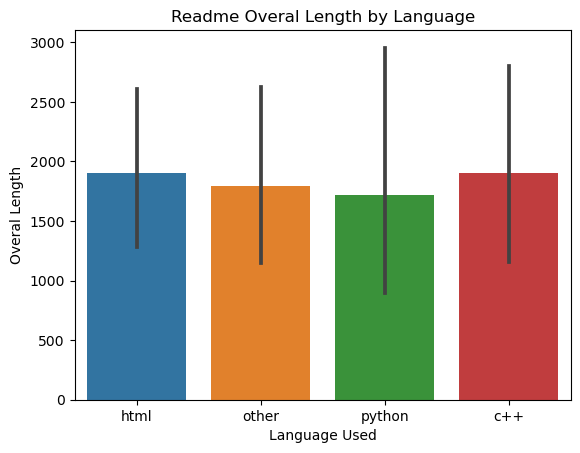

In [23]:
def length_viz(df):
    '''
    This function generates a visualization for lengths 
    of readmes by language; input should be the training set
    '''
    lengths = []
    for x in df['model']:
        temp = len(x)
        lengths.append(temp)
    df['lengths'] = lengths
    viz001 = df[df['lengths'] < 8000]
    sns.barplot(data = viz001, x = 'language', y = 'lengths')
    plt.title('Readme Overal Length by Language')
    plt.ylabel('Overal Length')
    plt.xlabel('Language Used')
    return plt.show()

train = length_viz(train)

In [29]:
top_hack_bigrams = pd.DataFrame(top_hack_bigrams)
bigrams_list = top_hack_bigrams.index.tolist()
bigrams_list

[('pull', 'request'),
 ('github', 'github'),
 ('open', 'source'),
 ('', ''),
 ('computer', 'td'),
 ('aligncentera', 'width100px'),
 ('titlecode', 'computer'),
 ('td', 'td'),
 ('computer', 'science'),
 ('td', 'aligncentera')]

In [31]:
python_bigrams = pd.Series(nltk.ngrams(python_words, 2))
top_python_bigrams = pd.DataFrame(python_bigrams.value_counts().head(40))
top_python_bigrams.head()

,0
"(pull, request)",69
"(github, github)",45
"(open, source)",36
"(shirticonstshirtpng, stickersiconsstickerspng)",11
"(create, pull)",9


In [32]:
python_list = []
for x in top_python_bigrams.index:
    if x in bigrams_list:
        python_list.append(x)

In [33]:
python_list

[('pull', 'request'), ('github', 'github'), ('open', 'source')]

In [38]:
cplus_list = []
for x in top_cplus_bigrams.index:
    if x in bigrams_list:
        cplus_list.append(x)


In [39]:
cplus_list

[('computer', 'td'),
 ('pull', 'request'),
 ('aligncentera', 'width100px'),
 ('titlecode', 'computer'),
 ('open', 'source'),
 ('computer', 'science'),
 ('td', 'td'),
 ('td', 'aligncentera'),
 ('', ''),
 ('github', 'github')]

In [43]:
html_list = []
for x in top_html_bigrams.index:
    if x in bigrams_list:
        html_list.append(x)

In [44]:
html_list

[('pull', 'request'), ('open', 'source')]

In [40]:
cplus_bigrams = pd.Series(nltk.ngrams(cplus_words, 2))
top_cplus_bigrams = pd.DataFrame(cplus_bigrams.value_counts().head(40))
top_cplus_bigrams.head()

,0
"(computer, td)",87
"(pull, request)",87
"(aligncentera, width100px)",87
"(titlecode, computer)",87
"(open, source)",75


In [41]:
html_bigrams = pd.Series(nltk.ngrams(html_words, 2))
top_html_bigrams = pd.DataFrame(html_bigrams.value_counts().head(40))
top_html_bigrams.head()

,0
"(pull, request)",53
"(open, source)",31
"(bash, git)",13
"(repository, github)",12
"(make, sure)",10


In [50]:
other_bigrams = pd.Series(nltk.ngrams(other_words, 2))
top_other_bigrams = pd.DataFrame(other_bigrams.value_counts().head(40))
top_other_bigrams.T

,"(pull, request)","(open, source)","(fork, repository)","(make, sure)","(command, git)","(local, repository)","(git, add)","(git, clone)","(git, checkout)","(forked, repository)",...,"(new, file)","(forthebadge, forthebadge)","(aligncenter, img)","(add, git)","(terminal, command)","(readme, end)","(commit, change)","(repository, git)","(create, branch)","(programming, language)"
0,54,26,19,16,14,12,12,12,12,11,...,7,7,7,6,6,6,6,6,6,6


In [47]:
bigram_viz = []

In [49]:
bigram_viz['python'] = top_python_bigrams[top_python_bigrams[0] == '(pull, request)']

TypeError: list indices must be integers or slices, not str